#Questão 1

Considere os dados "SPECTF Heart" do site UCI (http://archive.ics.uci.edu/
dataset/96/spectf+heart). Concatene os datasets SPECTF.test e SPECTF.train
para formar o data set SPECTF com 267 individuos (linhas) descritos por 45
variaveis (colunas), sendo a primeira coluna a variavel de classe.

- Execute os algoritmos KFCM-K e KFCM-K-W.1 50 vezes para obter cada
  um uma partição fuzzy com c ∈ {2, 3, 4, 5}. Para cada c selecione o
  melhor resultado segundo a função objetivo. Para cada c obtenha a
  correspondente partição crisp a partir da melhor partição fuzzy. Para cada
  c e partição crisp calcule a silhueta (Sil). Faça o plot Sil ×c para
  c ∈ {2, 3, 4, 5} e escolha o numero de clusters: c∗ = arg maxc Sil(c).

- Para cada algoritmo e melhor partição fuzzy com c∗, calcule o Modified partition coefficient. Comente.

- Para cada algoritmo e partição crisp correspondente a melhor partição
  fuzzy com c∗ , calcule o índice de Rand corrigido. Comente. Parametros: T = 100;  e = 10−6; m = 1.1;

- Para cada algoritmo e melhor resultado segundo a função objetivo com c∗
  mostrar: i) os protótipos de cada grupo (g1, . . . , gc ); ii) o vetor de
  parametros de largura de cada grupo (s1, . . . , sc ) iii) a matrix de confusão da partição crisp versus a partição a priori; iv) o plot da função objetivo versus as iterações;

# Bibliotecas

In [146]:
!pip install ucimlrepo

In [147]:
import json
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from collections import defaultdict
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

#Base de dados

In [148]:
# fetch dataset
spect_heart = fetch_ucirepo(id=96)

# data (as pandas dataframes)
X = spect_heart.data.features
y = spect_heart.data.targets

In [149]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 44 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   F1R     267 non-null    int64
 1   F1S     267 non-null    int64
 2   F2R     267 non-null    int64
 3   F2S     267 non-null    int64
 4   F3R     267 non-null    int64
 5   F3S     267 non-null    int64
 6   F4R     267 non-null    int64
 7   F4S     267 non-null    int64
 8   F5R     267 non-null    int64
 9   F5S     267 non-null    int64
 10  F6R     267 non-null    int64
 11  F6S     267 non-null    int64
 12  F7R     267 non-null    int64
 13  F7S     267 non-null    int64
 14  F8R     267 non-null    int64
 15  F8S     267 non-null    int64
 16  F9R     267 non-null    int64
 17  F9S     267 non-null    int64
 18  F10R    267 non-null    int64
 19  F10S    267 non-null    int64
 20  F11R    267 non-null    int64
 21  F11S    267 non-null    int64
 22  F12R    267 non-null    int64
 23  F12S    267 non

#Pré processamento

In [150]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#Métricas de avaliação

##Silhueta

In [151]:
def plot_silhouette_scores(X, crispys_list, n_clusters):

    silhouette_scores = []

    # Calcula os índices de silhueta para cada partição crisp
    for crispy_c in crispys_list:
        for partition in crispy_c:
            sil_score = silhouette_score(X, partition)
            silhouette_scores.append(sil_score)

    # Identifica o melhor número de clusters (c*)
    best_c_index = np.argmax(silhouette_scores)
    best_c = n_clusters[best_c_index]
    max_silhouette = silhouette_scores[best_c_index]

    # Plota o gráfico de silhueta para o melhor número de clusters (c)
    plt.figure(figsize=(8, 6))
    plt.plot(n_clusters, silhouette_scores, marker='o', label='Índice de Silhueta')
    plt.axvline(best_c, color='red', linestyle='--', label=f'Melhor c* = {best_c}')
    plt.title("Gráfico Silhouette × Número de Clusters (c)")
    plt.xlabel("Número de Clusters (c)")
    plt.ylabel("Índice de Silhueta (Sil)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"O melhor número de clusters é c* = {best_c}, com silhueta média = {max_silhouette:.2f}")

## Modified Partition Coeficient (MPC)

In [152]:
def calculate_mpc(Us):

    Us = np.array(Us)
    c, n = Us.shape[1], len(Us)
    PC = (1 / n) * np.sum(Us**2)
    MPC = (PC - (1 / c)) / (1 - (1 / c))

    return MPC

## Vetor de parametro de largura

In [153]:
def calculate_cluster_widths(X, prototypes, crisp_partition):

    cluster_widths = []
    n_clusters = len(prototypes)

    for i in range(n_clusters):
        # Identifica os índices dos pontos pertencentes ao cluster i
        cluster_points = X[crisp_partition == i]

        # Se o cluster não tiver pontos atribuídos, definir largura como 0
        if len(cluster_points) == 0:
            cluster_widths.append(0)
            continue

        # Calcula a largura como a distância média entre os pontos e o protótipo
        distances = np.linalg.norm(cluster_points - prototypes[i], axis=1)
        cluster_width = np.mean(distances)
        cluster_widths.append(cluster_width)

    return cluster_widths

## Matriz de confusão

In [154]:
def matriz_confusao(y, best_crisp_partition):
  # Calcula a matriz de confusão
  cm = confusion_matrix(y, best_crisp_partition)

  # Plota a matriz de confusão usando ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(cmap='Blues', values_format='d')

  # Configura título e labels
  plt.title(f"Matriz de Confusão para c* = {c_star}")
  plt.xlabel("Rótulos Preditos")
  plt.ylabel("Rótulos Verdadeiros")
  plt.show()

##Plotar valores de J

In [155]:
def plot_J_values(J_values):
    plt.figure(figsize=(8, 6))
    plt.plot(J_values, marker='o')
    plt.title("Função Objetivo versus Iterações")
    plt.xlabel("Iterações")
    plt.ylabel("Função Objetivo (J)")
    plt.grid()
    plt.show()

#Parâmetros

In [156]:
n_clusters = [2, 3, 4, 5]
sigma = 0.5
T = 100
e = 1e-6
m = 1.1

#KFCM-K

##Algoritmo

In [157]:
#Iniciar centroides aleatoriamente
def init_G(n_clusters, columns_len):
  return np.random.rand(n_clusters, columns_len)

#função de Kernel (K)
def kernel_function(Xk, Gi, sigma):

  distances = 0

  for i in range(len(Xk)):
      distances += (Xk[i] - Gi[i])**2
  kernel = np.exp(-0.5 * distances * 1/sigma**2)

  return kernel

In [158]:
#Função de membership (U)
def calculate_membership(Xk, Gi, G, m):
  U = 0
  Uki = 0

  K_Gi = kernel_function(Xk, Gi, m)
  for Gh in G:
    K_Gh = kernel_function(Xk, Gh, m)

    Uki += ((1-K_Gi)/(1-K_Gh))**(1/(m-1))

  U = 1/Uki

  return U

In [159]:
#Função de atualização de prototipos/centroides (G)
def update_G(X, Us, Kernels, m):
  n_cluster = len(Us[0])
  G_new = []

  # Para cada cluster i, calcula o novo centro G_i
  for i in range(n_cluster):
    numerator = np.zeros(X[0].shape)
    denominator = 0

    for k in range(len(X)):
      uki_m = Us[k][i] ** m
      kernel_val = Kernels[k][i]

      numerator += uki_m * kernel_val * X[k]
      denominator += uki_m * kernel_val

    G_new.append(numerator / denominator)

  return G_new

In [160]:
#Função objetivo (J)
def calculate_J(Us, Kernels, m, n_cluster):
    J = 0
    for i in range(n_cluster):
        for k in range(len(Us)):
            J += (Us[k][i] ** m) * (2 - 2 * Kernels[k][i])
    return J

In [161]:
def pipeline(X, n_cluster, columns_len, sigma, m, n_runs):
    best_J = float('inf')
    best_G = None
    J_values = []
    G_values = []
    # Inicialização dos centros dos clusters
    G = init_G(n_cluster, columns_len)

    for _ in range(n_runs):
        Kernels = []
        Us = []

        # Calcula o kernel e os graus de pertencimento
        for Xk in X.values:
            k_temp = []
            uki_temp = []
            for Gi in G:
                K = kernel_function(Xk, Gi, sigma)
                Uki = calculate_membership(Xk, Gi, G, m)
                k_temp.append(K)
                uki_temp.append(Uki)
            Kernels.append(k_temp)
            Us.append(uki_temp)

        # Atualização dos centros dos clusters G
        G = update_G(X.values, Us, Kernels, m)
        G_values.append(G)

        # Cálculo da função objetivo J usando a função externa
        J = calculate_J(Us, Kernels, m, n_cluster)
        J_values.append(J)

        # Atualiza o melhor J e os centros G associados se J atual for menor
        if J < best_J:
            best_J = J
            best_G = G

    return J_values, G_values, best_J, best_G, Us

## Aplicação

In [162]:
results_2 = []
results_3 = []
results_4 = []
results_5 = []

results_list = [results_2, results_3, results_4, results_5]

mpc_values = []

for c, results_c in zip(n_clusters, results_list):
    J_values, G_values, best_J, best_G, Us = pipeline(X, c, len(X.columns), sigma, m, n_runs=T)
    results_c.append({'J': {'best': best_J, 'values': J_values}, 'G':{'best': best_G, 'values': G_values}, 'U': Us})
    mpc = calculate_mpc(Us)
    mpc_values.append({'c': c, 'mpc': mpc})

In [163]:
crispy_2 = []
crispy_3 = []
crispy_4 = []
crispy_5 = []
fuzzy_2 = []
fuzzy_3 = []
fuzzy_4 = []
fuzzy_5 = []

crispys_list = [crispy_2, crispy_3, crispy_4, crispy_5]

fuzzys_list = [fuzzy_2, fuzzy_3, fuzzy_4, fuzzy_5]

for results_c, fuzzy_c, crispy_c in zip(results_list, fuzzys_list, crispys_list):
  u_c = results_c[0]['U']
  fuzzy_c.append(u_c)
  for instancia in fuzzy_c:
    crispy_c.append(np.argmax(instancia, axis=1))

## Escolha de c*

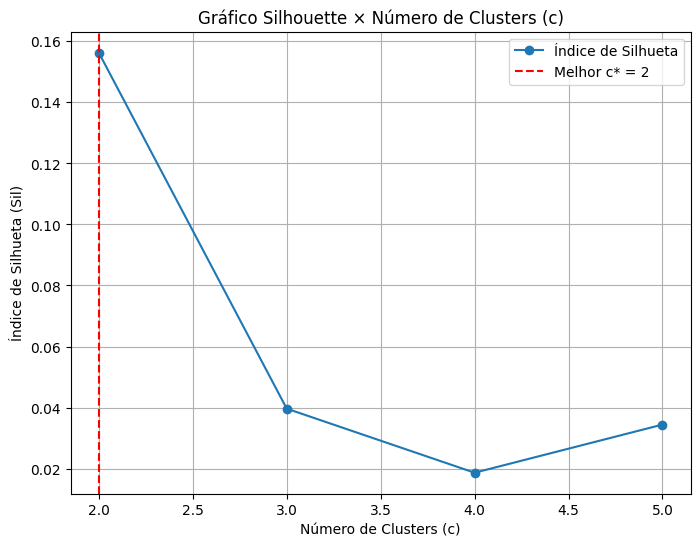

O melhor número de clusters é c* = 2, com silhueta média = 0.16


In [164]:
plot_silhouette_scores(X, crispys_list, n_clusters)

## Resultados de c*

In [165]:
best_c_index = np.argmin([result['J']['best'] for result in results_list[0]])
c_star = n_clusters[best_c_index]
best_prototypes = results_list[best_c_index][0]['G']['best']
best_crisp_partition = crispys_list[best_c_index][0]

### MPC para partição fuzzy de c*

In [166]:
mpc_values[best_c_index]

{'c': 2, 'mpc': 0.7113954890262182}

### Índice de Rand ajustado para partição crispy de c*

In [167]:
rand_index = adjusted_rand_score(list(y['diagnosis']), crispys_list[best_c_index][0])
print(f"c = {c_star}, rand = {rand_index}")

c = 2, rand = 0.08015751198007198


### Protótipos de cada grupo (g1, .... gc) de c*

In [168]:
for i, prototype in enumerate(best_prototypes):
    print(f"Protótipo g{i+1} para c*={c_star}: {prototype}")

Protótipo g1 para c*=2: [0.77271237 0.81205997 0.72931362 0.7622471  0.70210675 0.60809015
 0.78831109 0.82195877 0.85528674 0.81101758 0.88712323 0.88688444
 0.78211429 0.7722399  0.68832736 0.74086392 0.85395151 0.79894564
 0.64580076 0.79477127 0.78552745 0.74200937 0.69969513 0.64839029
 0.64155193 0.61959553 0.76031196 0.64557779 0.77444742 0.78734373
 0.82442497 0.85453597 0.69058213 0.71882946 0.81293145 0.80883098
 0.74545663 0.82437375 0.76625414 0.77837535 0.71686793 0.65770553
 0.54918278 0.62697428]
Protótipo g2 para c*=2: [0.73283811 0.74289625 0.71701957 0.72968237 0.77174383 0.67794198
 0.80000384 0.82706035 0.81451966 0.74813421 0.85626036 0.84339034
 0.80839617 0.82227466 0.80860345 0.83510501 0.86673806 0.80326103
 0.6512106  0.77146321 0.78242909 0.73661845 0.77621558 0.7427944
 0.80958005 0.79627022 0.80622341 0.68723747 0.81447574 0.84499362
 0.82417295 0.85663536 0.70077886 0.73482362 0.83798573 0.83538911
 0.70611086 0.77254411 0.84847507 0.8600813  0.85657276 0.

### Vetor de parametros de largura de cada grupo de c*

In [169]:
cluster_widths = calculate_cluster_widths(X.values, best_prototypes, best_crisp_partition)
print(f"Vetor de parâmetros de largura para c*={c_star}:")
for i, width in enumerate(cluster_widths):
    print(f"s{i+1} = {width:.4f}")

Vetor de parâmetros de largura para c*=2:
s1 = 1.0959
s2 = 0.6327


### Matriz de confusão da partição crispy versus a partição a priori (y) para c*

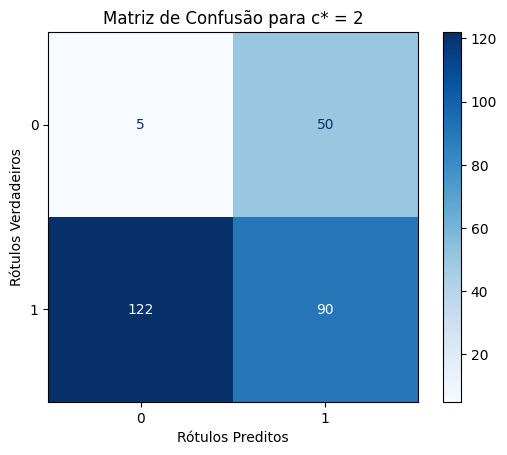

In [170]:
matriz_confusao(y, best_crisp_partition)

###Plot da função objetivo (J) versus as iterações para c*

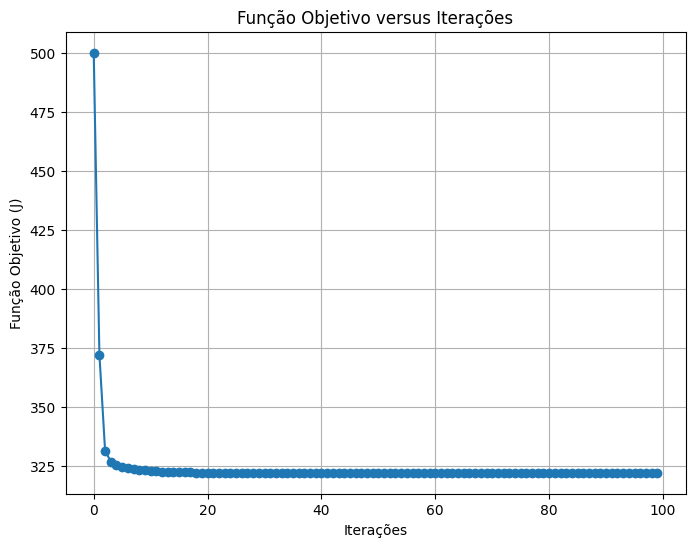

In [171]:
plot_J_values(results_list[best_c_index][0]['J']['values'])

# KFCM-K-W.1

In [172]:
# Inicializar centroides aleatoriamente
def init_G(n_clusters, columns_len):
    return np.random.rand(n_clusters, columns_len)

# Inicializar os pesos (w)
def init_weights(X):
    return np.ones(X.shape[1]) / X.shape[1]

In [173]:
# Função de Kernel (K) considerando os pesos
def kernel_function_weighted(Xk, Gi, sigma, weights):
    distances = 0
    for i in range(len(Xk)):
        distances += weights[i] * (Xk[i] - Gi[i])**2
    kernel = np.exp(-0.5 * distances / sigma**2)
    return kernel

In [174]:
# Função de membership (U) considerando os pesos
def calculate_membership_weighted(Xk, Gi, G, m, weights, sigma):
    U = 0
    Uki = 0

    K_Gi = kernel_function_weighted(Xk, Gi, sigma, weights)
    for Gh in G:
        K_Gh = kernel_function_weighted(Xk, Gh, sigma, weights)
        Uki += ((1 - K_Gi) / (1 - K_Gh)) ** (1 / (m - 1))

    U = 1 / Uki
    return U

In [175]:
# Atualizar os pesos das características (w)
def update_weights(X, G, Us, Kernels, m):
    n_features = X.shape[1]
    n_clusters = len(G)
    weights = np.zeros(n_features)

    for j in range(n_features):
        numerator = 0
        denominator = 0

        for i in range(n_clusters):
            for k in range(len(X)):
                uki_m = Us[k][i] ** m
                numerator += uki_m * (X[k][j] - G[i][j])**2
                denominator += uki_m

        weights[j] = 1 / (numerator / (denominator + 1e-10) + 1e-10)  # Evitar divisão por zero

    # Normaliza os pesos para que a soma seja 1
    weights /= weights.sum()
    return weights

In [176]:
# Função de atualização de protótipos/centroides (G)
def update_G_weighted(X, Us, Kernels, m, weights):
    n_cluster = len(Us[0])
    G_new = []

    for i in range(n_cluster):
        numerator = np.zeros(X[0].shape)
        denominator = 0

        for k in range(len(X)):
            uki_m = Us[k][i] ** m
            kernel_val = Kernels[k][i]

            numerator += uki_m * kernel_val * X[k]
            denominator += uki_m * kernel_val

        G_new.append(numerator / (denominator + 1e-10))  # Evitar divisão por zero

    return G_new

In [177]:
# Função objetivo (J)
def calculate_J_weighted(Us, Kernels, m, n_cluster):
    J = 0
    for i in range(n_cluster):
        for k in range(len(Us)):
            J += (Us[k][i] ** m) * (2 - 2 * Kernels[k][i])
    return J

In [178]:
def pipeline_weighted(X, n_cluster, columns_len, sigma, m, n_runs):
    best_J = float('inf')
    best_G = None
    best_weights = None
    J_values = []
    G_values = []
    weights = init_weights(X)

    # Inicialização dos centros dos clusters
    G = init_G(n_cluster, columns_len)

    for _ in range(n_runs):
        Kernels = []
        Us = []

        # Calcula o kernel e os graus de pertencimento
        for Xk in X.values:
            k_temp = []
            uki_temp = []
            for Gi in G:
                K = kernel_function_weighted(Xk, Gi, sigma, weights)
                Uki = calculate_membership_weighted(Xk, Gi, G, m, weights, sigma)
                k_temp.append(K)
                uki_temp.append(Uki)
            Kernels.append(k_temp)
            Us.append(uki_temp)

        # Atualização dos centros dos clusters G
        G = update_G_weighted(X.values, Us, Kernels, m, weights)
        G_values.append(G)

        # Atualização dos pesos das características
        weights = update_weights(X.values, G, Us, Kernels, m)

        # Cálculo da função objetivo J
        J = calculate_J_weighted(Us, Kernels, m, n_cluster)
        J_values.append(J)

        # Atualiza o melhor J, os centros G e os pesos associados se J atual for menor
        if J < best_J:
            best_J = J
            best_G = G
            best_weights = weights

    return J_values, G_values, best_J, best_G, best_weights, Us

In [179]:
results_2 = []
results_3 = []
results_4 = []
results_5 = []

results_list = [ results_2, results_3, results_4, results_5]

mpc_values = []

for c, results_c in zip(n_clusters, results_list):
    J_values, G_values, best_J, best_G, Us = pipeline(X, c, len(X.columns), sigma, m, n_runs=T)
    results_c.append({'J': {'best': best_J, 'values': J_values}, 'G':{'best': best_G, 'values': G_values}, 'U': Us})
    mpc = calculate_mpc(Us)
    mpc_values.append({'c': c, 'mpc': mpc})

In [180]:
crispy_2 = []
crispy_3 = []
crispy_4 = []
crispy_5 = []
fuzzy_2 = []
fuzzy_3 = []
fuzzy_4 = []
fuzzy_5 = []

crispys_list = [crispy_2, crispy_3, crispy_4, crispy_5]

fuzzys_list = [fuzzy_2, fuzzy_3, fuzzy_4, fuzzy_5]

for results_c, fuzzy_c, crispy_c in zip(results_list, fuzzys_list, crispys_list):
  u_c = results_c[0]['U']
  fuzzy_c.append(u_c)
  for instancia in fuzzy_c:
    crispy_c.append(np.argmax(instancia, axis=1))

## Escolha de c*

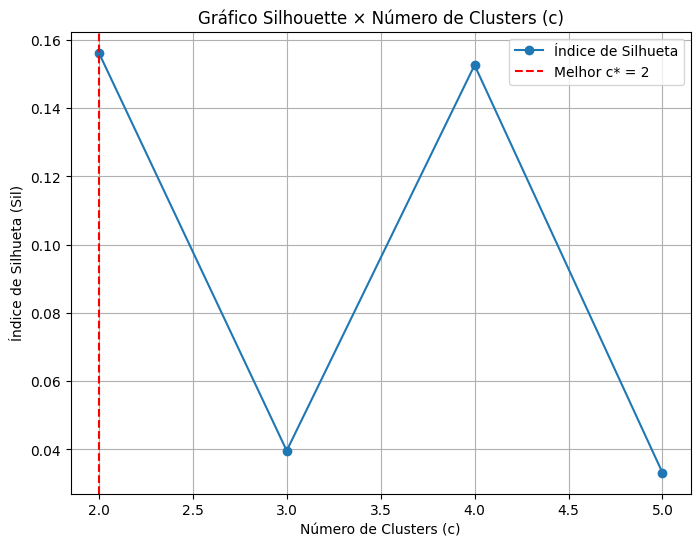

O melhor número de clusters é c* = 2, com silhueta média = 0.16


In [181]:
plot_silhouette_scores(X, crispys_list, n_clusters)

## Resultados de c*

In [182]:
best_c_index = np.argmin([result['J']['best'] for result in results_list[0]])
c_star = n_clusters[best_c_index]
best_prototypes = results_list[best_c_index][0]['G']['best']
best_crisp_partition = crispys_list[best_c_index][0]

### MPC para partição fuzzy de c*

In [183]:
mpc_values[best_c_index]

{'c': 2, 'mpc': 0.7113954887244702}

### Índice de Rand ajustado para partição crispy de c*

In [185]:
rand_index = adjusted_rand_score(list(y['diagnosis']), crispys_list[best_c_index][0])
print(f"c = {c_star}, rand = {rand_index}")

c = 2, rand = 0.08015751198007198


### Protótipos de cada grupo (g1, .... gc) de c*

In [186]:
for i, prototype in enumerate(best_prototypes):
    print(f"Protótipo g{i+1} para c*={c_star}: {prototype}")

Protótipo g1 para c*=2: [0.73283811 0.74289625 0.71701957 0.72968237 0.77174383 0.67794198
 0.80000384 0.82706035 0.81451966 0.74813421 0.85626036 0.84339034
 0.80839617 0.82227466 0.80860345 0.83510501 0.86673806 0.80326103
 0.6512106  0.77146321 0.78242909 0.73661845 0.77621558 0.7427944
 0.80958005 0.79627022 0.80622341 0.68723747 0.81447574 0.84499362
 0.82417295 0.85663536 0.70077886 0.73482362 0.83798573 0.83538911
 0.70611086 0.77254411 0.84847507 0.8600813  0.85657276 0.82489385
 0.69241774 0.80388359]
Protótipo g2 para c*=2: [0.77271237 0.81205997 0.72931362 0.7622471  0.70210675 0.60809015
 0.78831109 0.82195877 0.85528674 0.81101758 0.88712323 0.88688444
 0.78211429 0.7722399  0.68832736 0.74086392 0.85395151 0.79894564
 0.64580076 0.79477127 0.78552745 0.74200937 0.69969513 0.64839029
 0.64155193 0.61959553 0.76031196 0.64557779 0.77444742 0.78734373
 0.82442497 0.85453597 0.69058213 0.71882946 0.81293145 0.80883098
 0.74545663 0.82437375 0.76625414 0.77837535 0.71686793 0.

### Vetor de parametros de largura de cada grupo de c*

In [187]:
cluster_widths = calculate_cluster_widths(X.values, best_prototypes, best_crisp_partition)
print(f"Vetor de parâmetros de largura para c*={c_star}:")
for i, width in enumerate(cluster_widths):
    print(f"s{i+1} = {width:.4f}")

Vetor de parâmetros de largura para c*=2:
s1 = 0.6327
s2 = 1.0959


### Matriz de confusão da partição crispy versus a partição a priori (y) para c*

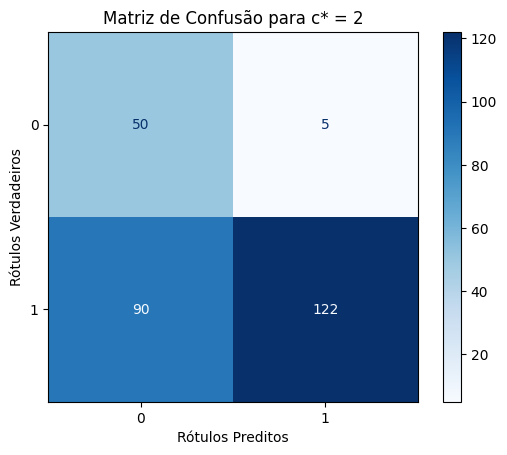

In [188]:
matriz_confusao(y, best_crisp_partition)

###Plot da função objetivo (J) versus as iterações para c*

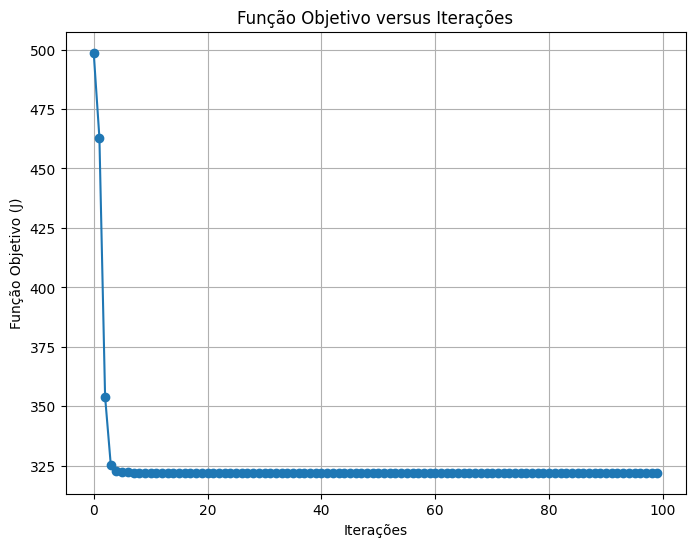

In [189]:
plot_J_values(results_list[best_c_index][0]['J']['values'])